In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split, KFold
from sklearn.naive_bayes import GaussianNB
import seaborn as sns
import Columns

PERCENT = lambda x: x*100

In [2]:
'''
Load the data into a pandas dataframe
'''
col_names = Columns.names
data = pd.read_csv('spambase.data', header=None, names = list(range(1,59)))

'''Mapping for column names for our understanding'''
for i, col in enumerate(col_names):
    print("{} : {}".format(i+1,col))

1 : word_freq_make
2 : word_freq_address
3 : word_freq_all
4 : word_freq_3d
5 : word_freq_our
6 : word_freq_over
7 : word_freq_remove
8 : word_freq_internet
9 : word_freq_order
10 : word_freq_mail
11 : word_freq_receive
12 : word_freq_will
13 : word_freq_people
14 : word_freq_report
15 : word_freq_addresses
16 : word_freq_free
17 : word_freq_business
18 : word_freq_email
19 : word_freq_you
20 : word_freq_credit
21 : word_freq_your
22 : word_freq_font
23 : word_freq_000
24 : word_freq_money
25 : word_freq_hp
26 : word_freq_hpl
27 : word_freq_george
28 : word_freq_650
29 : word_freq_lab
30 : word_freq_labs
31 : word_freq_telnet
32 : word_freq_857
33 : word_freq_data
34 : word_freq_415
35 : word_freq_85
36 : word_freq_technology
37 : word_freq_1999
38 : word_freq_parts
39 : word_freq_pm
40 : word_freq_direct
41 : word_freq_cs
42 : word_freq_meeting
43 : word_freq_original
44 : word_freq_project
45 : word_freq_re
46 : word_freq_edu
47 : word_freq_table
48 : word_freq_conference
49 : char_f

In [3]:
data.head()

,1,2,3,4,5,6,7,8,9,10,...,49,50,51,52,53,54,55,56,57,58
0,0.00,0.64,0.64,0.0,0.32,0.00,0.00,0.00,0.00,0.00,...,0.00,0.000,0.0,0.778,0.000,0.000,3.756,61,278,1
1,0.21,0.28,0.50,0.0,0.14,0.28,0.21,0.07,0.00,0.94,...,0.00,0.132,0.0,0.372,0.180,0.048,5.114,101,1028,1
2,0.06,0.00,0.71,0.0,1.23,0.19,0.19,0.12,0.64,0.25,...,0.01,0.143,0.0,0.276,0.184,0.010,9.821,485,2259,1
3,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,...,0.00,0.137,0.0,0.137,0.000,0.000,3.537,40,191,1
4,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,...,0.00,0.135,0.0,0.135,0.000,0.000,3.537,40,191,1


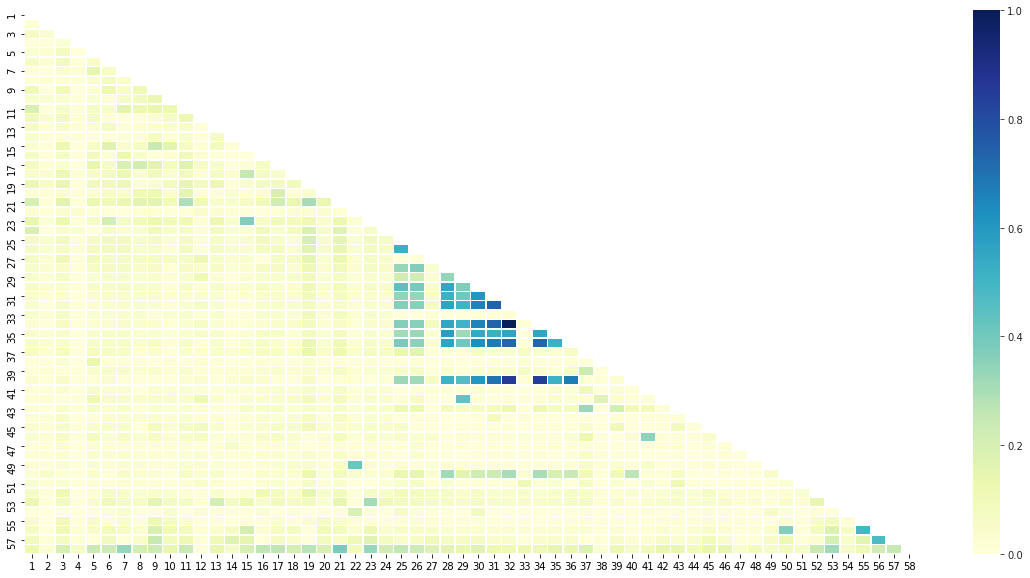

In [4]:
'''Visualize correlation of features'''
corr_matrix = data.corr().abs()

'''Plot the heatmap for the correlation matrix'''
mask = np.zeros_like(corr_matrix)
mask[np.triu_indices_from(mask)] = True
_, size = plt.subplots(figsize=(20,10))
with sns.axes_style("white"):
    ax = sns.heatmap(corr_matrix, mask=mask, ax=size, linewidths=.5, cmap="YlGnBu")

In [5]:
'''
Remove correlated features because they are voted twice in the model and it can lead to over inflating importance.

Get highly correlated column pairs and drop one of them. We only look at the upper triangle of the correlation matrix so as to get rid of one feature from every highly correlated pair. In our case we drop columns with correlation greater than 0.95
'''

upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]

if to_drop:
    print("Columns dropped : {}".format(to_drop))
    data.drop(to_drop, axis=1, inplace=True)

print("Final Columns = {}".format(data.columns))

Columns dropped : [34]
Final Columns = Int64Index([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
            18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 35,
            36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52,
            53, 54, 55, 56, 57, 58],
           dtype='int64')


In [6]:
'''
Split the data to keep aside a test set which'll be used once we're done training the model.
We might not need this for our particular case as we're not tuning any hyperparameters and get an average error from k-fold cross validation itself. If we were using DecisionTrees for instance, we could've tuned the max_depth value using cross_val and tested it's accuracy on the test set.
'''

X_train, X_test = train_test_split(data, test_size=0.8, shuffle=True)

'''Get input features and the corresponding target values'''
X = X_train.iloc[:, :-1]
y = X_train.iloc[:,-1]

print("The reasons for the indices not being in order and not starting from 0 are the train_test_split and the shuffling of data before the split")

X.head()

The reasons for the indices not being in order and not starting from 0 are the train_test_split and the shuffling of data before the split


,1,2,3,4,5,6,7,8,9,10,...,48,49,50,51,52,53,54,55,56,57
2861,0.00,0.00,0.00,0.0,0.00,0.0,0.00,0.00,0.00,0.29,...,0.29,0.0,0.273,0.0,0.000,0.000,0.000,3.317,75,282
3003,0.47,0.00,0.62,0.0,0.00,0.0,0.00,0.00,0.15,0.00,...,0.00,0.0,0.052,0.0,0.105,0.079,0.026,1.962,13,155
156,0.00,0.00,0.00,0.0,1.31,0.0,1.31,1.31,1.31,1.31,...,0.00,0.0,0.000,0.0,0.117,0.117,0.000,48.500,186,291
1644,0.22,0.88,0.44,0.0,0.22,0.0,0.00,0.00,1.32,1.54,...,0.00,0.0,0.085,0.0,0.659,0.114,0.028,9.100,65,728
644,0.89,0.00,0.89,0.0,0.00,0.0,1.78,0.00,0.00,0.00,...,0.00,0.0,0.000,0.0,1.344,0.000,0.000,5.250,16,84


In [12]:
'''
1. Create k partitions of the training set
2. Go over every partition useing it as test set while using the rest for training
3. Get the confusion matrix, which in our case can be simple done by calculating y_test-y_pred :
    -1 -> False positive (0 misclassified as 1)
     1 -> False negative (1 misclassified as 0)
'''

kf = KFold(n_splits=10, shuffle=True)
kf.get_n_splits(X)

metric_columns = ["FP Rate (0 misclassified as 1)", "FN Rate (1 misclassified as 0)", "Error"]

final_metrics = list()
for split in kf.split(X):
    train_index, test_index = split
    
    Xtrain, Xtest = X.iloc[train_index,], X.iloc[test_index]
    ytrain, ytest = y.iloc[train_index,], y.iloc[test_index]
    
    '''Test samples that are spam and not spam, used for FN rate and FP rate'''
    spam = len(ytest==1)
    non_spam = len(ytest==0)
    
    '''Train NB Classifier and make a prediction on the test set'''
    clf = GaussianNB()
    clf.fit(Xtrain, ytrain)
    ypred = clf.predict(Xtest)
    
    '''Manually computing false +ves and false -ves. We'll eventually use values from sklearn confusion matrix'''
    misclassified = (ytest-ypred)
    FP = np.count_nonzero(misclassified==-1)
    FN = np.count_nonzero(misclassified==1)
    
    #print("FPR = {}, FNR = {}".format(FP/non_spam, FN/spam))
    
    tn, fp, fn, tp = confusion_matrix(ytest, ypred).ravel()
    error = 1-accuracy_score(ytest, ypred) 
    
    final_metrics.append((fp/non_spam, fn/spam, error))

final_metrics_df = pd.DataFrame(final_metrics, columns = metric_columns)

In [15]:
'''Get the Mean of all folds and add an accuracy column'''
final_metrics_df.loc['Mean'] = final_metrics_df.mean()
final_metrics_df['Accuracy %'] = PERCENT(1-final_metrics_df['Error'])
final_metrics_df = final_metrics_df.round(4)

final_metrics_df.rename_axis('Fold', inplace=True)
final_metrics_df

,FP Rate (0 misclassified as 1),FN Rate (1 misclassified as 0),Error,Accuracy %
Fold,,,,
0,0.1413,0.0217,0.1630,83.7000
1,0.1630,0.0000,0.1630,83.7000
2,0.1413,0.0000,0.1413,85.8700
3,0.1957,0.0109,0.2065,79.3500
4,0.1630,0.0109,0.1739,82.6100
5,0.0870,0.0543,0.1413,85.8700
6,0.0978,0.0217,0.1196,88.0400
7,0.0978,0.0435,0.1413,85.8700
8,0.0435,0.0326,0.0761,92.3900


In [9]:
x_test = X_test.iloc[:,:-1]
y_test = X_test.iloc[:,-1]
y_pred = clf.predict(x_test)

In [10]:
print("Accuracy on test set {:2.2f}%".format(PERCENT(accuracy_score(y_test, y_pred))))

Accuracy on test set 82.97%
